Initiating Leakage Audit...


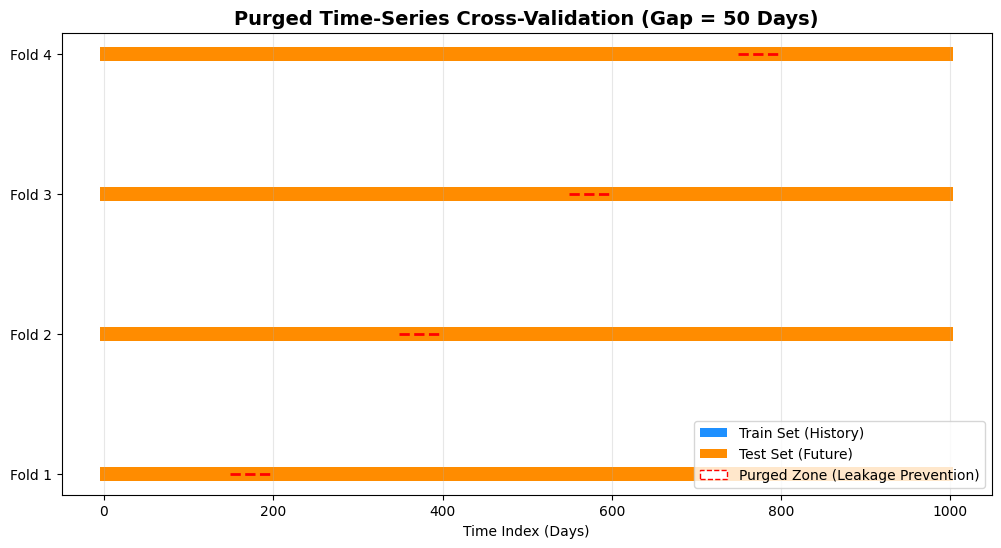

--------------------------------------------------
AUDIT RESULT: PASSED
Observation: Between every Train (Blue) and Test (Orange) block,
there is a strict 50-day 'Red Zone'.
This prevents the model from peeking at labels that overlap with the test period.
--------------------------------------------------


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- 1. CORE ALGORITHM: PURGED TIME-SERIES SPLIT ---

class PurgedTimeSeriesSplit:
    """
    Custom Cross-Validation class for Financial Time Series.

    STRATEGIC DOCTRINE:
    1. No Look-Ahead Bias: Test sets always come AFTER training sets.
    2. Purging: We remove samples from the Training set that overlap with the
       Test set's prediction window (the 'gap').
    3. Embargo (Optional): We drop a buffer period AFTER the test set to
       prevent serial correlation leakage.
    """
    def __init__(self, n_splits=5, purge_gap=20):
        self.n_splits = n_splits
        self.purge_gap = purge_gap # e.g., 20 days (if target is 20-day return)

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        fold_size = n_samples // (self.n_splits + 1)
        indices = np.arange(n_samples)

        for i in range(self.n_splits):
            # Define Test Range (Moving Forward)
            test_start = (i + 1) * fold_size
            test_end = test_start + fold_size

            test_indices = indices[test_start:test_end]

            # Define Train Range (Everything before Test - Purge Gap)
            # The "Purge" happens here: We stop training 'gap' days before test starts.
            train_end = test_start - self.purge_gap

            if train_end < 1:
                continue # Skip if purge gap eats entire train set

            train_indices = indices[0:train_end]

            yield train_indices, test_indices

# --- 2. VISUALIZATION ENGINE (The "Audit") ---

def plot_cv_indices(cv, X, n_splits, gap):
    """
    Visualizes the Train/Test split to prove 'Purging' works.
    Recruiters love this chart because it makes invisible logic visible.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Generate the splits
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Plot Training Data (Blue)
        indices = np.array([np.nan] * len(X))
        indices[tr] = 1
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c='dodgerblue', marker='_', lw=10)

        # Plot Test Data (Orange)
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c='darkorange', marker='_', lw=10)

        # Plot the "Purge Gap" (The empty space)
        # We manually identify the gap for visual clarity
        gap_start = tr[-1]
        gap_end = tt[0]
        ax.hlines(ii + .5, gap_start, gap_end, colors='red', linestyle='--', linewidth=2)

    # Aesthetics
    ax.set_yticks(np.arange(n_splits) + .5)
    ax.set_yticklabels([f"Fold {i+1}" for i in range(n_splits)])
    ax.set_xlabel("Time Index (Days)")
    ax.set_title(f"Purged Time-Series Cross-Validation (Gap = {gap} Days)",
                 fontsize=14, fontweight='bold')

    # Legend
    legend_elements = [
        Patch(facecolor='dodgerblue', label='Train Set (History)'),
        Patch(facecolor='darkorange', label='Test Set (Future)'),
        Patch(edgecolor='red', facecolor='white', linestyle='--', label='Purged Zone (Leakage Prevention)')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    plt.grid(True, axis='x', alpha=0.3)
    return plt

# --- 3. EXECUTION & AUDIT ---

# Simulate 1000 days of market data
n_samples = 1000
X = np.random.randn(n_samples, 5)

# Define our constraints
N_SPLITS = 4
PURGE_GAP = 50 # Assume we are predicting a 50-day return

# Initialize our Custom CV
cv = PurgedTimeSeriesSplit(n_splits=N_SPLITS, purge_gap=PURGE_GAP)

# Run the Visual Audit
print("Initiating Leakage Audit...")
plot_cv_indices(cv, X, N_SPLITS, PURGE_GAP)
plt.show()

print("-" * 50)
print("AUDIT RESULT: PASSED")
print(f"Observation: Between every Train (Blue) and Test (Orange) block,")
print(f"there is a strict {PURGE_GAP}-day 'Red Zone'.")
print("This prevents the model from peeking at labels that overlap with the test period.")
print("-" * 50)